In [1]:
import os

import numpy as np
from scipy.stats import sem
import gymnasium as gym

import gym_env
import seaborn as sns
import matplotlib.pyplot as plt

from models import SR_IS_TwoStep, SR_TwoStep, MB_TwoStep, Hybrid_TwoStep
from utils import decision_policy, policy_reval, softmax
from utils_render import plot_decision_prob_two_step

In [2]:
save_dir = os.path.join('..', 'figures/')
colors = [9, 1]

In [3]:
set_val = 1
lambd = set_val
alpha = 0.05
beta = set_val
num_steps = 250
num_seeds = 500

prob_train_SR_IS, prob_test_SR_IS = [[],[]], [[], []]
prob_train_SR, prob_test_SR = [[],[]], [[], []]
prob_train_MB, prob_test_MB = [[],[]], [[], []]
prob_train_Hybrid, prob_test_Hybrid = [[],[]], [[], []]

for i in range(num_seeds):
    seed = int(i)
    agent_MB = MB_TwoStep(policy="softmax", seed=seed)
    # Learn
    agent_MB.update_V()
    
    # Original decision policy
    probs = softmax(np.array([agent_MB.V[1], agent_MB.V[2]]), beta)
    prob_train_MB[0].append(probs[0])
    prob_train_MB[1].append(probs[1])
    # Update experiment
    agent_MB.update_exp()
    agent_MB.update_V()
    # Reval decision policy
    probs = softmax(np.array([agent_MB.V[1], agent_MB.V[2]]), beta)
    prob_test_MB[0].append(probs[0])
    prob_test_MB[1].append(probs[1])

for i in range(num_seeds):
    seed = int(i)
    agent_SR_IS =  SR_IS_TwoStep(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, seed=seed)
    agent_SR = SR_TwoStep(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", seed=seed)
    agent_Hybrid = Hybrid_TwoStep(alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", seed=seed)
    
    # Learn
    agent_SR_IS.learn()
    agent_SR.learn()
    agent_Hybrid.learn()
    
    ##  SR-IS  ##
    # Original decision policy
    probs = softmax(np.array([agent_SR_IS.V[1], agent_SR_IS.V[2]]), beta)
    prob_train_SR_IS[0].append(probs[0])
    prob_train_SR_IS[1].append(probs[1])
    # Update experiment
    agent_SR_IS.update_exp()
    V_new, Z_new = policy_reval(agent_SR_IS)
    # Reval decision policy
    probs = softmax(np.array([V_new[1], V_new[2]]), beta)
    prob_test_SR_IS[0].append(probs[0])
    prob_test_SR_IS[1].append(probs[1])

    ##  SR  ##
    # Original decision policy
    probs = softmax(np.array([agent_SR.V[1], agent_SR.V[2]]), beta)
    prob_train_SR[0].append(probs[0])
    prob_train_SR[1].append(probs[1])
    # Update experiment
    agent_SR.update_exp()
    agent_SR.update_V()
    # Reval decision policy
    probs = softmax(np.array([agent_SR.V[1], agent_SR.V[2]]), beta)
    prob_test_SR[0].append(probs[0])
    prob_test_SR[1].append(probs[1])
    
    ##  Hybrid SR-MB  ##
    # Original decision policy
    probs = softmax(np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), beta)
    prob_train_Hybrid[0].append(probs[0])
    prob_train_Hybrid[1].append(probs[1])
    # Update experiment
    agent_Hybrid.update_exp()
    agent_Hybrid.update_V()
    # Reval decision policy
    probs = softmax(np.array([agent_Hybrid.V[1], agent_Hybrid.V[2]]), beta)
    prob_test_Hybrid[0].append(probs[0])
    prob_test_Hybrid[1].append(probs[1])
    

# Plotting

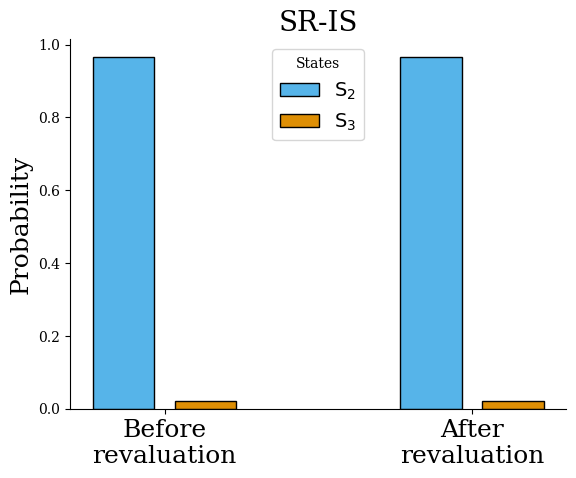

In [4]:
##   Plot SR-IS  ##
prob_train = [np.mean(prob_train_SR_IS[0]), np.mean(prob_train_SR_IS[1])]
prob_test = [np.mean(prob_test_SR_IS[0]), np.mean(prob_test_SR_IS[1])]
std_train = [sem(prob_train_SR_IS[0]), sem(prob_train_SR_IS[1])]
std_test = [sem(prob_test_SR_IS[0]), sem(prob_test_SR_IS[1])]
save_path = save_dir + "two_step_SR-IS.png"
plot_decision_prob_two_step(
    probs_train=prob_train,
    probs_test=prob_test,
    colors=colors,
    title='SR-IS',
    ylabel="Probability",
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test],
    ymax=1.0,
    start_i=1,
    remove_spine=True,
)

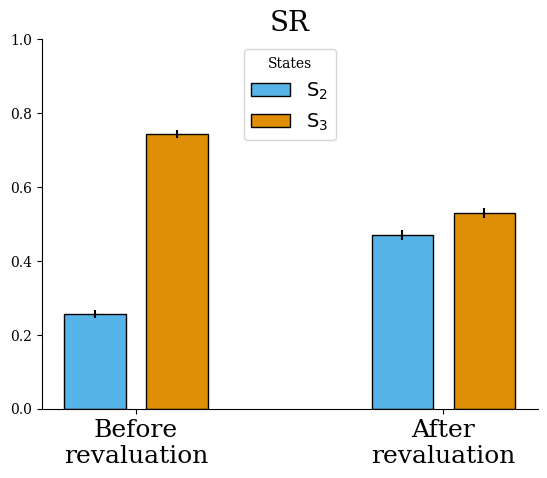

In [10]:
##   Plot SR  ##
prob_train = [np.mean(prob_train_SR[0]), np.mean(prob_train_SR[1])]
prob_test = [np.mean(prob_test_SR[0]), np.mean(prob_test_SR[1])]
std_train = [sem(prob_train_SR[0]), sem(prob_train_SR[1])]
std_test = [sem(prob_test_SR[0]), sem(prob_test_SR[1])]
save_path = save_dir + "two_step_SR.png"
plot_decision_prob_two_step(
    probs_train=prob_train,
    probs_test=prob_test,
    colors=colors,
    title='SR',
    ylabel=None,
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test],
    ymax=1.0,
    start_i=1,
    remove_spine=True,
)

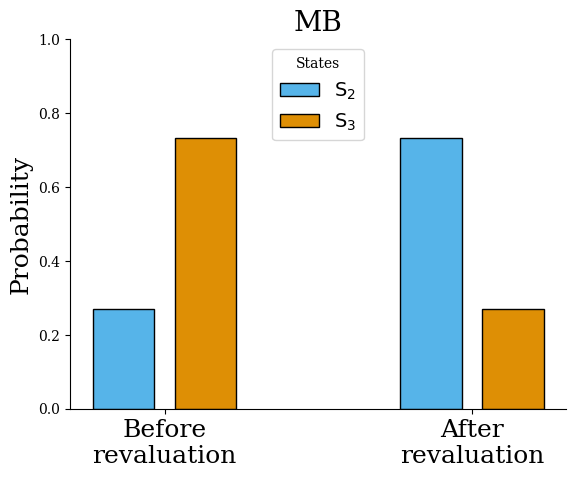

In [9]:
##   Plot MB  ##
prob_train_mb = [np.mean(prob_train_MB[0]), np.mean(prob_train_MB[1])]
prob_test_mb = [np.mean(prob_test_MB[0]), np.mean(prob_test_MB[1])]
std_train_mb = [sem(prob_train_MB[0]), sem(prob_train_MB[1])]
std_test_mb = [sem(prob_test_MB[0]), sem(prob_test_MB[1])]
save_path = save_dir + "two_step_MB.png"
plot_decision_prob_two_step(
    probs_train=prob_train_mb,
    probs_test=prob_test_mb,
    colors=colors,
    title='MB',
    ylabel="Probability",
    leg_loc="upper center",
    save_path=None,
    std=[std_train_mb, std_test_mb],
    ymax=1.0,
    start_i=1,
    remove_spine=True,
)

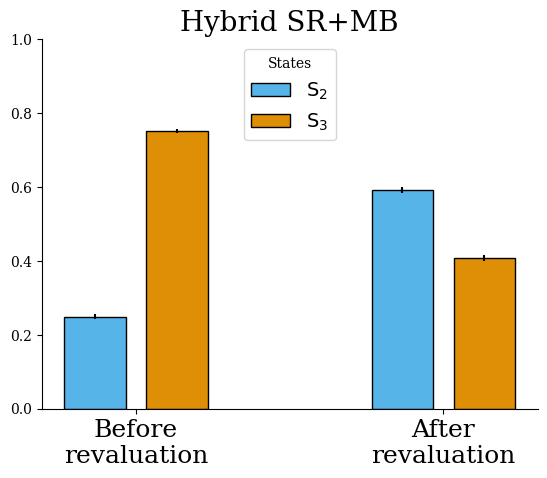

In [8]:
##   Plot Hybrid SR-MB  ##
prob_train = [np.mean(prob_train_Hybrid[0]), np.mean(prob_train_Hybrid[1])]
prob_test = [np.mean(prob_test_Hybrid[0]), np.mean(prob_test_Hybrid[1])]
std_train = [sem(prob_train_Hybrid[0]), sem(prob_train_Hybrid[1])]
std_test = [sem(prob_test_Hybrid[0]), sem(prob_test_Hybrid[1])]
save_path = save_dir + "two_step_Hybrid.png"
plot_decision_prob_two_step(
    probs_train=prob_train,
    probs_test=prob_test,
    colors=colors,
    title='Hybrid SR+MB',
    ylabel=None,
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test],
    ymax=1.0,
    start_i=1,
    remove_spine=True,
)